# llama3 implemented from scratch
in this file, i implemented llama3 from scratch, one tensor and matrix multiplication at a time.
<br>
also, im going to load tensors directly from the model file that meta provided for llama3, you need to download the weights before running this file.
here is the offical link to download the weights: https://llama.meta.com/llama-downloads/

<div>
    <img src="images/archi.png"/>
</div>

## tokenizer
im not going to implement a bpe tokenizer (but andrej karpathy has a really clean implementation)
<br>
link to his implementation: https://github.com/karpathy/minbpe

<div>
    <img src="images/karpathyminbpe.png" width="600"/>
</div>


In [2]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

tokenizer_path = "Meta-Llama-3-8B/tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

tokenizer.decode(tokenizer.encode("hello world!"))

'hello world!'

## reading the model file
normally, reading this depends on how the model classes are written and the variable names inside them.
<br>
but since we are implementing llama3 from scratch we will read the file one tensor at a time.
<div>
    <img src="images/model.png" width="600"/>
</div>

In [3]:
model = torch.load("Meta-Llama-3-8B/consolidated.00.pth")
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [5]:
with open("Meta-Llama-3-8B/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

## we use this config to infer details about the model like
1. the model has 32 transformer layers
2. each multi-head attention block has 32 heads
3. the vocab size and so on

In [6]:
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

## converting text to tokens
here we use tiktoken (i think an openai library) as the tokenizer
<div>
    <img src="images/tokens.png" width="600"/>
</div>

In [7]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


## converting tokens to their embedding
IM SORRY but this is the only part of the codebase where i use an inbuilt neural network module
<br>
anyway, so our [17x1] tokens are now [17x4096], i.e. 17 embeddings (one for each token) of length 4096
<br>
<br>
note: keep track of the shapes, it makes it much easier to understand everything

<div>
    <img src="images/embeddings.png" width="600"/>
</div>

In [8]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

## we then normalize the embedding using rms normalization
please, note after this step the shapes dont change, the values are just normalized
<br>
things to keep in mind, we need a norm_eps (from config) because we dont want to accidently set rms to 0 and divide by 0
<br>
here is the formula:
<div>
    <img src="images/rms.png" width="600"/>
</div>

In [9]:
# def rms_norm(tensor, norm_weights):
#     rms = (tensor.pow(2).mean(-1, keepdim=True) + norm_eps)**0.5
#     return tensor * (norm_weights / rms)
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

# building the first first layer of the transformer

### normalization
you will see me accessing layer.0 from the model dict (this is the first layer)
<br>
anyway, so after normalizing our shapes are still [17x4096] same as embedding but normalized 

<div>
    <img src="images/norm.png" width="600"/>
</div>

In [10]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
token_embeddings.shape

torch.Size([17, 4096])

### attention implemented from scratch
let's load the attention heads of the first layer of the transformer
<div>
    <img src="images/qkv.png" width="600"/>
</div>

<br>

&gt; when we load the query, key, value and output vectors from the model we notice the shapes to be [4096x4096], [1024x4096], [1024x4096], [4096x4096]
<br>
&gt; at first glance this is weird because ideally we want each q,k,v and o for each head individually
<br>
&gt; the authors of the code bundled them togeather because its easy it helps parallize attention head multiplication.
<br>
&gt; im going to unwrap everything... 

In [11]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


### unwrapping query
in the next section we will unwrap the queries from multiple attention heads, the resulting shape is [32x128x4096]
<br><br>
here, 32 is the number of attention heads in llama3, 128 is the size of the query vector and 4096 is the size of the token embedding

In [12]:
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
q_layer0.shape

torch.Size([32, 128, 4096])

### im going to implement the first head of the first layer
here i access the query weight matrix first head of the first layer, the size of this query weight matrix is [128x4096]

In [13]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

### we now multiply the query weights with the token embedding, to recive a query for the token
here you can see the resulting shape is [17x128], this is because we have 17 tokens and for each token there is a 128 length query.
<div>
    <img src="images/q_per_token.png" width="600"/>
</div>

In [14]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([17, 128])

## positioning encoding
we are now at a stage where we have a query vector for each token in our prompt, but if you think about it -- the indivitually query vector has no idea about the position in the prompt.
<br><br>
query: "the answer to the ultimate question of life, the universe, and everything is "
<br><br>
in our prompt we have used "the" three times, we need the query vectors of all 3 "the" tokens to have different query vectors (each of size [1x128]) based on their positions in the query. we perform these rotations using RoPE (rotory positional embedding).
<br><br>
### RoPE
watch this video (this is what i watched) to understand the math.
https://www.youtube.com/watch?v=o29P0Kpobz0&t=530s


<div>
    <img src="images/rope.png" width="600"/>
</div>

In [15]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

in the above step, we split the query vectors into pairs, we apply a rotational angle shift to each pair!
<br><br>
we now have a vector of size [17x64x2], this is the 128 length queries split into 64 pairs for each token in the prompt! each of those 64 pairs will be rotated by m*(theta) where m is the position of the token for which we are rotating the query!


<div>
    <img src="images/qsplit.png" width="600"/>
</div>

## using dot product of complex numbers to rotate a vector
<div>
    <img src="images/freq_cis.png" width="600"/>
</div>

In [16]:
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [17]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

RuntimeError: Numpy is not available

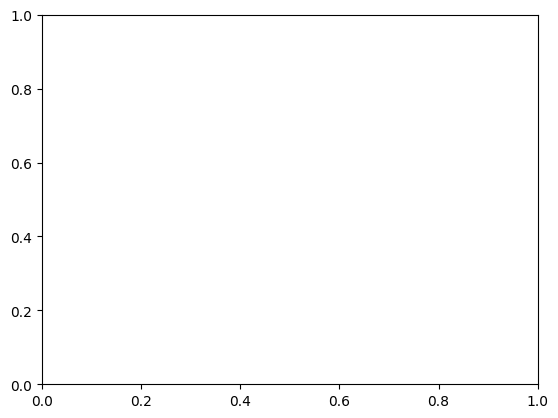

In [18]:
freqs_for_each_token = torch.outer(torch.arange(17), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# viewing tjhe third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

### now that we have a complex number (the angle change vector) for every token's query element
we can convert our queries (the one we split into pairs) as complex numbers and then dot product to rotate the query based on the position
<br>
honeslty this is beautiful to think about :)

In [19]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [20]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

torch.Size([17, 64])

### after rotated vector is obtained
we can get back our the queries as pairs by viewing the complex numbers as real numbers again

In [21]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

the rotated pairs are now merged, we now have a new query vector (rotated query vector) that is of the shape [17x128] where 17 is the number of tokens and the 128 is the dim of the query vector

In [22]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([17, 128])

# keys (almost the same as queries)
<div>
    <img src="images/keys.png" width="600px"/>
</div>
im lazy as fuck, so im not going to go through the math for keys, the only things you need to keep in mind are:
<br>
&gt; keys generate key vectors also of dimention 128
<br>
&gt; keys have only 1/4th the number of the weights as queries, this is because the weights for keys are shared across 4 heads at a time, to reduce the number of computations need
<br>
&gt; keys are also rotated to add positional info, just like queries because of the same reasons 

In [23]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape

torch.Size([8, 128, 4096])

In [24]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [25]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([17, 128])

In [26]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [27]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [28]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [29]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([17, 128])

## at this stage now have both the rotated values of queries and keys, for each token. 
<div>
    <img src="images/keys0.png" width="600px"/>
</div>
each of the queries and keys are now of shape [17x128]. 

## in the next step we will multiply the queries and key matrices
doing this will give us a score mapping each token with one another
<br>
this score describes how well each token's query relates to the each tokens's key. 
THIS IS SELF ATTENTION :)
<br>
the shape of the attention score matrix (qk_per_token) is [17x17] where 17 is the number of tokens in the prompt

<div>
    <img src="images/qkmatmul.png" width="600px"/>
</div>

In [30]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([17, 17])

# we now have to mask query key scores
during the training process of llama3, the future token qk scores are masked.
<br>
why? because during training we only learn to predict tokens using past tokens.
<br>
as a result, during inference we set the future tokens to zero.
<div>
    <img src="images/mask.png" width="600px"/>
</div>

RuntimeError: Numpy is not available

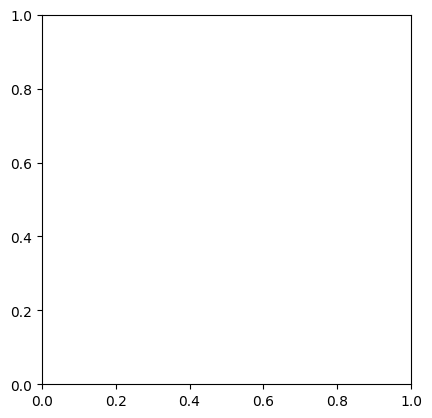

In [31]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [32]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

RuntimeError: Numpy is not available

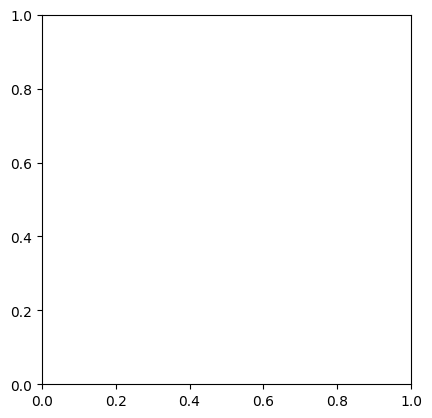

In [33]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

<div>
    <img src="images/softmax.png" width="600px"/>
</div>

RuntimeError: Numpy is not available

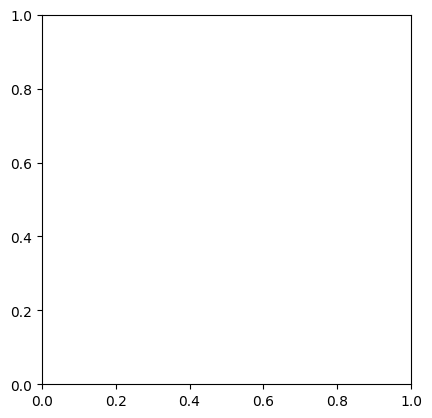

In [34]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

## values (almost the end of attention)

<div>
    <img src="images/value.png" width="600px"/>
</div>
these scores (0-1) are used to determine how much of value matrix is used per token
<br>
&gt; just like keys, value weights are also shared acorss every 4 attention heads (to save computation)
<br>
&gt; as a result, the shape of the value weight matrix below is [8x128x4096]


In [35]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

torch.Size([8, 128, 4096])

the first layer, first head value weight matrix is given below

In [36]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

## value vectors
<div>
    <img src="images/v0.png" width="600px"/>
</div>
we now use the value weghts to get the attention values per token, this is of size [17x128] where 17 is the number of tokens in the prompt and 128 is the dim of the value vector per token

In [37]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([17, 128])

## attention
<div>
    <img src="images/attention.png" width="600px"/>
</div>
the resultant attention vector after multipying with the values per token is of shape [17*128]

In [38]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([17, 128])

# multi head attention
<div>
    <img src="images/heads.png" width="600px"/>
</div>
WE NOW HAVE THE ATTENTION VALUE OF THE FIRST LAYER AND FIRST HEAD
<br>
now im going to run a loop and perform the exact same math as the cells above but for every head in the first layer

In [39]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

<div>
    <img src="images/stacked.png" width="600px"/>
</div>
we now have a the qkv_attention matrix for all 32 heads on the first layer, next im going to merge all attention scores into one large matrix of size [17x4096]
<br>
we are almost at the end :)

In [40]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([17, 4096])

# weight matrix, one of the final steps
<div>
    <img src="images/weightmatrix.png" width="600px"/>
</div>
one of the last things to do for a layer 0 attention is, is to multiply the weight matrix of the 

In [41]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

### this is a simple linear layer, so we just matmul

In [42]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([17, 4096])

<div>
    <img src="images/afterattention.png" width="600px"/>
</div>
we now have the change in the embedding value after attention, that should be adding to the original token embeddings

In [43]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([17, 4096])

## we normalize and then run a feed forward neural network through the embedding delta
<div>
    <img src="images/norm_after.png" width="600px"/>
</div>

In [44]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
embedding_after_edit_normalized.shape

torch.Size([17, 4096])

## loading the ff weights and implementing the feed forward network
<div>
    <img src="images/swiglu.png" width="600px"/>
</div>
in llama3, they used a SwiGLU feedforward network, this network architecture is really good at adding non linearity when needed by the model.
<br>
its pretty standard to use this feed forward network architecture in llms these days

In [45]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([17, 4096])

# WE FINALLY HAVE NEW EDITED EMBEDDINGS FOR EACH TOKEN AFTER THE FIRST LAYER
just 31 more layers to go before we are done (one for loop away)
<br>
you can imagine this edited embedding as having information about all queries asked on the first layer
<br>
now each layer will encode more and more complex queries on the quesions asked, until we have an embedding that knows everything about the next token that we need.

In [46]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([17, 4096])

# god, everything all at once
<div>
    <img src="images/god.png" width="600px"/>
</div>
yep, this is it. everything we did before, all at once, for every single layer.
<br>

# have fun reading :)

In [47]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

# we now have the final embedding, the best guess the model could make about the next token
the shape of the embedding is the same as regular token embeddings [17x4096] where 17 is the number of tokens and 4096 is the embedding dim
<div>
    <img src="images/last_norm.png" width="600px"/>
</div>

In [49]:
final_embedding = rms_norm(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([17, 4096])

# finally, lets decode the embedding into the token value
<div>
    <img src="images/finallayer.png" width="600px"/>
</div>
we will use the output decoder to convert the final embedding into a token

In [50]:
model["output.weight"].shape

torch.Size([128256, 4096])

# we use the embedding of the last token to predict the next value
hopefully in our case, 42 :)
note: 42 is the answer to "the answer to the ultimate question of life, the universe, and everything is ", according to the book "hitchhiker's guide to the galaxy", most mordern llms would answer with 42 here, which should validate our entire code! wish me luck :)

In [51]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

### the model predicted token number 2983 as the next token, is this the token number for 42?
IM HYPING YOU UP, this is the last cell of code, hopefully you had fun :)

In [52]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983)

# lets fucking go
<div>
    <img src="images/42.png" width="600px"/>
</div>

In [53]:
tokenizer.decode([next_token.item()])

'42'

# thank you, i love you :)

This is the end. Hopefully you enjoyed reading it!

If you want to support my work

1. follow me on twitter https://twitter.com/naklecha 
2. or, buy me a coffee [https://www.buymeacoffee.com/naklecha](https://www.buymeacoffee.com/naklecha)

Honestly, if you made it this far you already made my day :)

## what motivates me?

My friends and I are on a mission - to make research more accessible!
We created a research lab called A10 - [AAAAAAAAAA.org](http://aaaaaaaaaa.org/)

A10 twitter - https://twitter.com/aaaaaaaaaaorg

our thesis:
<div>
    <img src="images/a10.png" width="600px"/>
</div>